In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [1]:
import os
import random
import h5py
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
%matplotlib inline

from glob import glob
from torch.utils import data

import monai.transforms as tf
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch


def split_subjects(total_list, ratio=0.2, val_list=None):
    if val_list:
        return [x for x in total_list if x not in val_list], val_list
    else:
        val_length = int(len(total_list) * ratio)
        random.shuffle(total_list)
        val_list, train_list = total_list[:val_length], total_list[val_length:]
        return train_list, val_list


/data2/swk/anaconda3/envs/torch38/lib/python3.8/site-packages/monai/transforms/post/dictionary.py:191: UserWarning: `threshold_values=True/False` is deprecated, please use `threshold=value` instead.
  warnings.warn("`threshold_values=True/False` is deprecated, please use `threshold=value` instead.")
/data2/swk/anaconda3/envs/torch38/lib/python3.8/site-packages/monai/data/dataset.py:625: UserWarning: tqdm is not installed, will not show the caching progress bar.
  warnings.warn("tqdm is not installed, will not show the caching progress bar.")


torch.Size([1, 1, 250, 250, 11]) torch.Size([1, 1, 250, 250, 11])
Original Size: (256, 256, 4) -> Resampled(1 x 1 x 1) Size: (250, 250, 11)


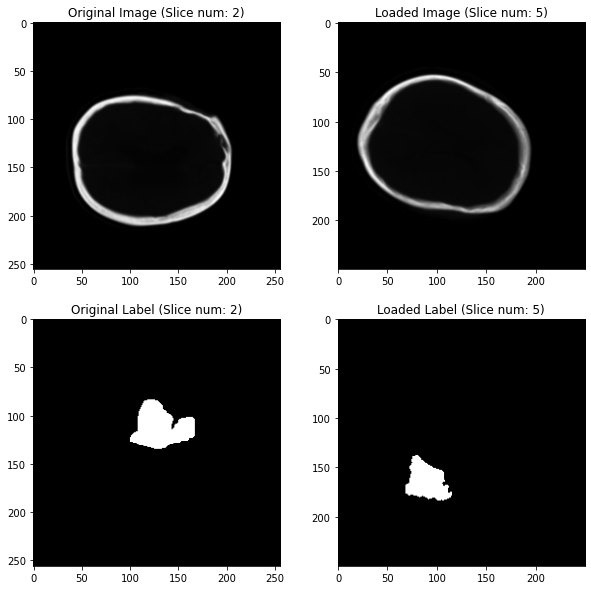

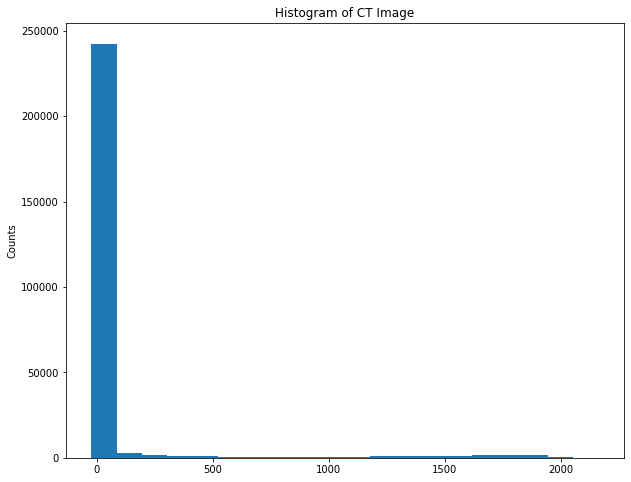

In [5]:
# train transforms
train_transforms = tf.Compose([
    tf.LoadImaged(reader="NibabelReader", keys=['image', 'label']),
    tf.AddChanneld(keys=['image', 'label']),
#     tf.Spacingd(keys=['image', 'label'], pixdim=(1., 1., 1.), diagonal=True),
    tf.ToTensord(keys=['image', 'label']),
    tf.AsDiscreted(keys=['label'], threshold_values=True),
    tf.ToNumpyd(keys=['image', 'label']),
    # tf.OneOf(transforms=oneof_transforms),
    tf.NormalizeIntensityd(keys=['image'], channel_wise=True),
#     tf.RandFlipd(keys=['image', 'label'], prob=0.5),
#     tf.RandCropByPosNegLabeld(
#         keys=['image', 'label'],
#         label_key='label',
#         spatial_size=(96,)*3,
#         pos=1,
#         neg=1,
#         num_samples=4,
#         image_key='image',
#         image_threshold=0
#     ),
    tf.ToTensord(keys=['image', 'label']),
    tf.DeleteItemsd(keys=['image_transforms', 'label_transforms'])
])

# validation and test transforms
val_transforms = tf.Compose([
    tf.LoadImaged(reader="NibabelReader", keys=['image', 'label']),
    tf.AddChanneld(keys=['image', 'label']),
#     tf.Spacingd(keys=['image', 'label'], pixdim=(1., 1., 1.), diagonal=True),
    tf.ToTensord(keys=['image', 'label']),
    tf.AsDiscreted(keys=['label'], threshold_values=True),
    tf.ToNumpyd(keys=['image', 'label']),
    tf.NormalizeIntensityd(keys=['image'], channel_wise=True),
    tf.ToTensord(keys=['image', 'label'])
])


# data_dir = "/scratch/sangwook/projects/dataset/isles_2018/ISLE2018"
data_dir = "/data2/swk/dataset/ISLES2018/ISLE2018"

total_subjects = glob(os.path.join(data_dir, 'ISLES2018_Training/TRAINING', '*'))
train_subjects, val_subjects = split_subjects(total_subjects)

modalities = ["CT", "CT_CBF", "CT_MTT", "CT_4DPWI", "CT_CBV", "CT_Tmax"]
# modalities = ["CT_4DPWI", "CT_CBV", "CT_Tmax"]
# image_modality = "CT_MTT"  # CT, CT_CBF, CT_MTT, CT_4DPWI, CT_CBV, CT_Tmax

for image_modality in modalities:

    train_CT = sorted([glob(os.path.join(x, f'*.{image_modality}.*', '*.nii')) for x in train_subjects])
    train_labels = sorted([glob(os.path.join(x, '*.OT.*', '*.nii')) for x in train_subjects])

    valid_CT = sorted([glob(os.path.join(x, f'*.{image_modality}.*', '*.nii')) for x in val_subjects])
    valid_labels = sorted([glob(os.path.join(x, '*.OT.*', '*.nii')) for x in val_subjects])

    train_files = [
        {'image': fl_name, 'label': label_name}
        for fl_name, label_name in zip(train_CT, train_labels)
    ]

    valid_files = [
        {'image': fl_name, 'label': label_name}
        for fl_name, label_name in zip(valid_CT, valid_labels)
    ]                    


    # train dataset
    train_dataset = CacheDataset(data=train_files,
                                 transform=train_transforms, 
                                 cache_rate=1.0)

    valid_dataset = CacheDataset(data=valid_files,
                                 transform=val_transforms,
                                 cache_rate=1.0)

    # train_dataset = Dataset(data=train_files,
    #                          transform=train_transforms)

    # valid_dataset = Dataset(data=valid_files,
    #                          transform=val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

    for batch in valid_loader:
        print(batch["image"].size(), batch["label"].size())        
        loaded_image = batch["image"].numpy().squeeze()
        loaded_label = batch["label"].numpy().squeeze()

        original_image = nib.load(valid_files[0]["image"][0]).get_fdata()
        original_label = nib.load(valid_files[0]["label"][0]).get_fdata()
        
        print(f"Original Size: {original_image.shape} -> Resampled(1 x 1 x 1) Size: {loaded_image.shape}")
        
        # Plot Images and Labels (from the original and loaded)
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        ax[0, 0].imshow(original_image[:, :, original_image.shape[-1]//2], cmap='gray')
        ax[0, 1].imshow(loaded_image[:, :, loaded_image.shape[-1]//2], cmap='gray')

        ax[0, 0].set_title(f"Original Image (Slice num: {original_image.shape[-1]//2})")
        ax[0, 1].set_title(f"Loaded Image (Slice num: {loaded_image.shape[-1]//2})")

        ax[1, 0].imshow(original_label[:, :, original_image.shape[-1]//2], cmap='gray')
        ax[1, 1].imshow(loaded_label[:, :, loaded_image.shape[-1]//2], cmap='gray')

        ax[1, 0].set_title(f"Original Label (Slice num: {original_image.shape[-1]//2})")
        ax[1, 1].set_title(f"Loaded Label (Slice num: {loaded_image.shape[-1]//2})")

        plt.show()
        plt.close()
        
        # Histogram
        plt.figure(figsize=(10, 8))
        plt.hist(original_image.flatten(), 20)
        plt.title(f"Histogram of {image_modality} Image")
        plt.ylabel("Counts")
        plt.show()
        plt.close()
        
        # Intensity Adjustments
#         fig, ax = plt.subplots(2, original_image.shape[-1], figsize=(22, 10))
#         plt.suptitle(f"ORIGINGAL {image_modality} IMAGE", y=0.95)
#         for slice_idx in range(original_image.shape[-1]):
#             im1 = ax[0, slice_idx].imshow(original_image[:, :, slice_idx], cmap='gray')
#             im2 = ax[1, slice_idx].imshow(original_label[:, :, slice_idx], cmap='gray')

#             divider = make_axes_locatable(ax[0, slice_idx])
#             cax = divider.append_axes('right', size='3%', pad=0.05)
#             fig.colorbar(im1, cax=cax, orientation='vertical')

#             divider = make_axes_locatable(ax[1, slice_idx])
#             cax = divider.append_axes('right', size='3%', pad=0.05)
#             fig.colorbar(im2, cax=cax, orientation='vertical')

#         plt.show()
#         plt.close()
        
#         # Intensity Adjustments
#         fig, ax = plt.subplots(3, original_image.shape[-1], figsize=(22, 15))
#         plt.suptitle(f"ORIGINGAL {image_modality} IMAGE (with Intensity Adjustment)", y=0.95)
#         for slice_idx in range(original_image.shape[-1]):
#             im1 = ax[0, slice_idx].imshow(original_image[:, :, slice_idx], cmap='gray', vmax=original_image.max()//4)
#             im2 = ax[1, slice_idx].imshow(original_image[:, :, slice_idx], cmap='gray', vmax=original_image.max()//6)
#             im2 = ax[1, slice_idx].imshow(original_image[:, :, slice_idx], cmap='gray', vmax=original_image.max()//6)

#             divider = make_axes_locatable(ax[0, slice_idx])
#             cax = divider.append_axes('right', size='3%', pad=0.05)
#             fig.colorbar(im1, cax=cax, orientation='vertical')

#             divider = make_axes_locatable(ax[1, slice_idx])
#             cax = divider.append_axes('right', size='3%', pad=0.05)
#             fig.colorbar(im2, cax=cax, orientation='vertical')

#         plt.show()
#         plt.close()
        
        break
    break

### 3D files -> 2D loading

1. Convert every nifiti file with 3D slices into 2D slices nifti files

In [3]:
from nilearn.image import resample_img
from shutil import rmtree
from tqdm import tqdm


def extract_seq(file_path):
    return os.path.basename(file_path).split('.')[4]


def save_nii(file_path, array_data, affine):
    nib.Nifti1Image(array_data, affine)
    
    
if __name__=="__main__":

    data_dir = "/data2/swk/dataset/ISLES2018/ISLE2018"

    total_subjects = glob(os.path.join(data_dir, 'ISLES2018_Training/TRAINING', '*'))
    train_subjects, val_subjects = split_subjects(total_subjects)
    test_subjects, val_subjects = split_subjects(val_subjects, ratio=0.5)
#     modalities = ["CT", "CT_CBF", "CT_MTT", "CT_4DPWI", "CT_CBV", "CT_Tmax"]
    modalities = ["CT", "CT_CBF", "CT_MTT", "CT_4DPWI", "CT_CBV", "CT_Tmax"]

    whole_dim_data = dict()

    phase_dict = dict(
        train=train_subjects,
        val=val_subjects,
        test=test_subjects
    )

    for phase, subject_list in phase_dict.items():

        phase_save_dir = os.path.join(data_dir, phase)
        if os.path.exists(phase_save_dir):
            rmtree(phase_save_dir)
        os.makedirs(phase_save_dir, exist_ok=True)

        for subject in tqdm(subject_list):
            seq_nii_files = glob(os.path.join(subject, '*/*.nii'))
            subject_name = os.path.basename(subject)

            for seq_file in seq_nii_files:
                seq_name = extract_seq(seq_file)
                nii_obj = nib.load(seq_file)
                nii_arr = nii_obj.get_fdata()
                num_slices = nii_arr.shape[2]
                
                for slice_idx in range(num_slices):
                    slice_arr = np.expand_dims(nii_arr[:, :, slice_idx], 2)
                    slice_nii_obj = nib.Nifti1Image(slice_arr, nii_obj.affine)
                    slice_save_path = os.path.join(phase_save_dir, f"{subject_name}-{seq_name}-{slice_idx}.nii.gz")
                    nib.save(slice_nii_obj, slice_save_path)
#                     print(f"{slice_save_path} successfully saved")
#                     break
#                 break
#             break
#         break


# Check before/after save
# fig, axes = plt.subplots(1, 2, figsize=(10, 8))
# plt.suptitle(f"{os.path.basename(slice_save_path).split('.')[0]}", y=0.8)
# axes[0].imshow(slice_arr.squeeze(), cmap='gray')
# axes[1].imshow(nib.load(slice_save_path).get_fdata().squeeze(), cmap='gray')
# plt.show()
# plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.67s/it]


### Check number of slices& pixdims

In [ ]:
root_dir = "/data2/swk/dataset/ISLES2018/ISLE2018"
save_dir = "/data2/swk/dataset/ISLES2018/ISLE20182D/"

total_subjects = glob(os.path.join(data_dir, 'ISLES2018_Training/TRAINING', '*'))
train_subjects, val_subjects = split_subjects(total_subjects)
sequences = ["CT", "CT_CBF", "CT_MTT", "CT_4DPWI", "CT_CBV", "CT_Tmax"]

whole_shape_data = dict()
whole_dim_data = dict()

for train_subject in total_subjects:
    seq_nii_files = glob(os.path.join(train_subject, '*/*.nii'))
    subject_shape_data = dict()
    subject_dim_data = dict()
    for seq_file in seq_nii_files:
        nii_obj = nib.load(seq_file)
        
        # shape
        subject_shape_data[extract_seq(seq_file)] = nii_obj.get_fdata().shape
        
        # pixdim
        subject_dim_data[extract_seq(seq_file)] = nii_obj.header['pixdim']
        
    whole_shape_data[os.path.basename(train_subject)] = subject_shape_data
    whole_dim_data[os.path.basename(train_subject)] = subject_dim_data

shape_df = pd.DataFrame.from_dict(whole_shape_data).T
dim_df = pd.DataFrame.from_dict(whole_dim_data).T

shape_df.to_excel("../asset/tables/shapes.xlsx")
dim_df.to_excel("../asset/tables/pixdims.xlsx")

### Skull Stripping

In [ ]:
# CT Skull Stripping

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(original_image.flatten(), 200)
plt.show()
plt.close()

fig, ax = plt.subplots(2, 2, figsize=(22, 10))
plt.suptitle(f"ORIGINGAL {image_modality} IMAGE", y=0.95)

threshold = 100

im1 = ax[0, 0].imshow(original_image[:, :, 0], cmap='gray')
im2 = ax[0, 1].imshow(np.where(original_image[:, :, 1] > threshold, 0, original_image[:, :, 1]), cmap='gray')
im3 = ax[1, 0].imshow(original_label[:, :, 0], cmap='gray')
im4 = ax[1, 1].imshow(original_label[:, :, 1], cmap='gray')

divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('right', size='3%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('right', size='3%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

torch.Size([1, 1, 220, 220, 151]) torch.Size([1, 1, 220, 220, 151])
Original Size: (256, 256, 2) -> Resampled(1 x 1 x 1) Size: (220, 220, 151)


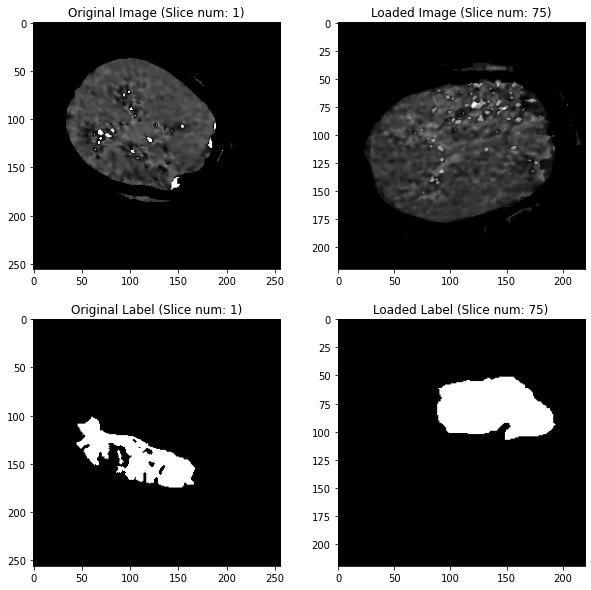

In [15]:
for batch in valid_loader:
    print(batch["image"].size(), batch["label"].size())
    break

loaded_image = batch["image"].numpy().squeeze()
loaded_label = batch["label"].numpy().squeeze()

original_image = nib.load(valid_files[0]["image"][0]).get_fdata()
original_label = nib.load(valid_files[0]["label"][0]).get_fdata()

print(f"Original Size: {original_image.shape} -> Resampled(1 x 1 x 1) Size: {loaded_image.shape}")

# Plot Images and Labels (from the original and loaded)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(original_image[:, :, original_image.shape[-1]//2], cmap='gray')
ax[0, 1].imshow(loaded_image[:, :, loaded_image.shape[-1]//2], cmap='gray')

ax[0, 0].set_title(f"Original Image (Slice num: {original_image.shape[-1]//2})")
ax[0, 1].set_title(f"Loaded Image (Slice num: {loaded_image.shape[-1]//2})")

ax[1, 0].imshow(original_label[:, :, original_image.shape[-1]//2], cmap='gray')
ax[1, 1].imshow(loaded_label[:, :, loaded_image.shape[-1]//2], cmap='gray')

ax[1, 0].set_title(f"Original Label (Slice num: {original_image.shape[-1]//2})")
ax[1, 1].set_title(f"Loaded Label (Slice num: {loaded_image.shape[-1]//2})")

plt.show()
plt.close()

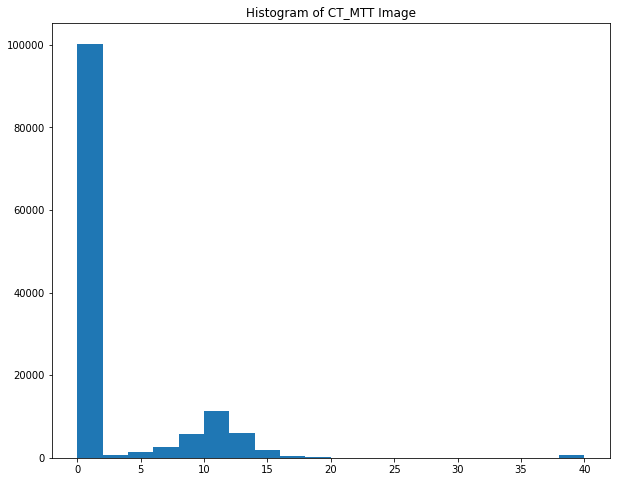

In [16]:
plt.figure(figsize=(10, 8))
plt.hist(original_image.flatten(), 20)
plt.title(f"Histogram of {image_modality} Image")
plt.show()
plt.close()

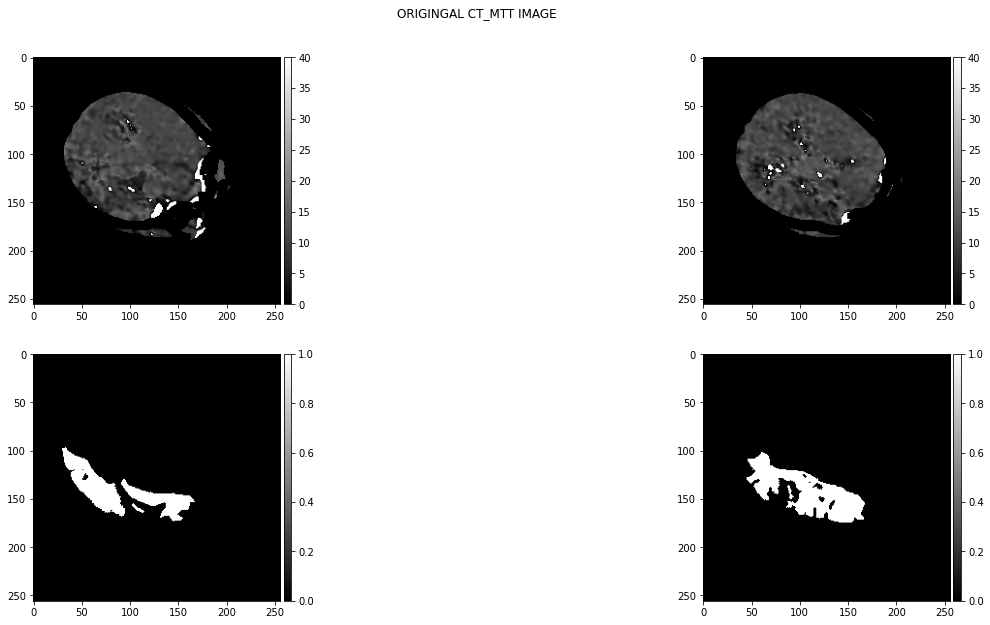

In [17]:
fig, ax = plt.subplots(2, original_image.shape[-1], figsize=(22, 10))
plt.suptitle(f"ORIGINGAL {image_modality} IMAGE", y=0.95)
for slice_idx in range(original_image.shape[-1]):
    im1 = ax[0, slice_idx].imshow(original_image[:, :, slice_idx], cmap='gray')
#     im1 = ax[0, slice_idx].imshow(original_image[:, :, slice_idx], cmap='gray', vmax=250)
#     im2 = ax[1, slice_idx].imshow(original_image[:, :, slice_idx], cmap='gray', vmax=125)
    im2 = ax[1, slice_idx].imshow(original_label[:, :, slice_idx], cmap='gray')
    
    divider = make_axes_locatable(ax[0, slice_idx])
    cax = divider.append_axes('right', size='3%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    
    divider = make_axes_locatable(ax[1, slice_idx])
    cax = divider.append_axes('right', size='3%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')
    
plt.show()
plt.close()

## Monai ImageReader

In [2]:
from typing import TYPE_CHECKING, Any, Callable, Dict, List, Optional, Sequence, Tuple, Union
from monai.config import DtypeLike, KeysCollection, PathLike
from monai.utils import require_pkg, optional_import
from monai.data.image_reader import ImageReader


@require_pkg(pkg_name="h5py")
class H5Reader(ImageReader):
    def __init__(self, channel_dim: Optional[int] = None, series_name: str = "", **kwargs):
        super().__init__()
        self.kwargs = kwargs
        self.channel_dim = channel_dim
        self.series_name = series_name
        
        
    def _read_h5_obj(self, path: Union[Sequence[PathLike], PathLike]):
        """
            |- mod 1
                 |- json
                 |- header (selected)
                 |- image
            |- mod 2
                 |- json
                 |- header (selected)
                 |- image
        """
        return h5py.File(path, 'r')
        
        
    def verify_suffix(self, filename: Union[Sequence[PathLike], PathLike]) -> bool:
        """
        Verify whether the specified `filename` is supported by the current reader.
        This method should return True if the reader is able to read the format suggested by the
        `filename`.

        Args:
            filename: file name or a list of file names to read.
                if a list of files, verify all the suffixes.

        """
        return (filename.lower().endswith('.hdf5')) or (filename.lower().endswith('.h5'))


    def read(self, data: Union[Sequence[PathLike], PathLike]) -> Union[Sequence[Any], Any]:
        """
        Read image data from specified file or files.
        Note that it returns a data object or a sequence of data objects.

        Args:
            data: file name or a list of file names to read.
            kwargs: additional args for actual `read` API of 3rd party libs.

        """
        img_ = []
        for file_name in data:
            with self._read_h5_obj(data) as f:
                img = f[self.kwargs["key"]]
                print(f)
            f.close()
            img_.append(img)
        return img_ if len(filenames) > 1 else img_[0]


    def get_data(self, img, **kwargs) -> Tuple[np.ndarray, Dict]:
        """
        Extract data array and meta data from loaded image and return them.
        This function must return two objects, the first is a numpy array of image data,
        the second is a dictionary of meta data.

        Args:
            img: an image object loaded from an image file or a list of image objects.

        """
        with self._read_h5_obj(img) as f:
            img = f[self.kwargs["key"]]["image"][()]
        f.close()
        return img, _
        
        
if __name__=="__main__":
    
    root_dir = "/scratch/sangwook/projects/dataset/isles_2018/ISLE2018_H5/"
    data_dir = os.path.join(root_dir, 'data')
    total_subject_list = glob(os.path.join(data_dir, "train", "*.hdf5"))
    
    train_list_path, val_list_path = split_subjects(total_subject_list, 0.2)
    test_list_path = glob(os.path.join(data_dir, "test", "*.hdf5"))
    
    train_transforms = tf.Compose([
        tf.LoadImage(reader=H5Reader(key="CT"), image_only=True)
    ])
    
    train_dataset = CacheDataset(data=train_list_path,
                                 transform=train_transforms,
                                 cache_rate=1.0)
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
    for batch in train_loader:
        print(batch)
        break
    

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
def load_dataset(root_dir, phase, **kwargs):
    """
    """
    
    data_dir = os.path.join(root_dir, 'data')
    total_subject_list = glob(os.path.join(data_dir, "train", "*.hdf5"))
    
    train_list_path, val_list_path = split_subjects(total_subject_list, 0.2)
    test_list_path = glob(os.path.join(data_dir, "train", "*.hdf5"))

    print('Loading files...')

    # training files (remove validation subjects after)
    # loading FLAIR only. Note that FLAIR is loaded as 'image' key in dict
    train_fl = sorted(glob.glob(os.path.join(data_dir, 'train_data', '*', '*T1acq_nu_FL.nii.gz')))
    train_labels = sorted(glob.glob(os.path.join(data_dir, 'train_data', '*', '*wmh_seg.nii.gz')))
    train_files = [
        {'image': fl_name, 'label': label_name}
        for fl_name, label_name in zip(train_fl, train_labels)
    ]

    # validation files
    with open(val_list_path) as f:
        val_subj_list = f.read().splitlines()
        val_files = [train_file for train_file in train_files if train_file['image'].split('/')[-2] in val_subj_list]
        train_files = [train_file for train_file in train_files if train_file['image'].split('/')[-2] not in val_subj_list]

    # test files
    test_fl = sorted(glob.glob(os.path.join(data_dir, 'test_data', '*', '*T1acq_nu_FL.nii.gz')))
    test_labels = sorted(glob.glob(os.path.join(data_dir, 'test_data', '*', '*wmh_seg.nii.gz')))
    test_files = [
        {'image': fl_name, 'label': label_name}
        for fl_name, label_name in zip(test_fl, test_labels)
    ]

    print(f'Loaded {len(train_files)} subjects for training.')
    print(f'Loaded {len(val_files)} subjects for validation.')
    print(f'Loaded {len(test_files)} subjects for testing.')


    ################################################################################
    ### DATASET AND DATALOADERS
    ################################################################################

    # train dataset
    train_dataset = CacheDataset(data=train_files, 
                                 transform=train_transforms, 
                                 cache_rate=1.0)

    # valid dataset
    val_dataset = CacheDataset(data=val_files, 
                               transform=val_transforms, 
                               cache_rate=1.0)

    # test dataset
    test_dataset = Dataset(data=test_files, 
                           transform=val_transforms)

    return train_dataset, val_dataset, test_dataset


In [ ]:
# import argparse
import glob
import os
import pickle
import time

import matplotlib.pyplot as plt
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import compute_hausdorff_distance, compute_meandice, DiceMetric, HausdorffDistanceMetric
from monai.networks.layers import Norm
from monai.networks.nets import UNet
import monai.transforms as tf
from monai.utils import get_torch_version_tuple, set_determinism
import numpy as np
import pandas as pd
import torch


################################################################################
### DATA SETUP
################################################################################


set_determinism(seed=0)

# get data files
data_dir = os.path.join(slurm_tmpdir, 'data', 'wmh_hab')
val_list_path = os.path.join(data_dir, 'wmh_validation_subjs.txt')

print('Loading files...')

# training files (remove validation subjects after)
# loading FLAIR only. Note that FLAIR is loaded as 'image' key in dict
train_fl = sorted(glob.glob(os.path.join(data_dir, 'train_data', '*', '*T1acq_nu_FL.nii.gz')))
train_labels = sorted(glob.glob(os.path.join(data_dir, 'train_data', '*', '*wmh_seg.nii.gz')))
train_files = [
    {'image': fl_name, 'label': label_name}
    for fl_name, label_name in zip(train_fl, train_labels)
]

# validation files
val_files = []
with open(val_list_path) as f:
    val_subj_list = f.read().splitlines()
    val_files = [train_file for train_file in train_files if train_file['image'].split('/')[-2] in val_subj_list]
    train_files = [train_file for train_file in train_files if train_file['image'].split('/')[-2] not in val_subj_list]

# test files
test_fl = sorted(glob.glob(os.path.join(data_dir, 'test_data', '*', '*T1acq_nu_FL.nii.gz')))
test_labels = sorted(glob.glob(os.path.join(data_dir, 'test_data', '*', '*wmh_seg.nii.gz')))
test_files = [
    {'image': fl_name, 'label': label_name}
    for fl_name, label_name in zip(test_fl, test_labels)
]

print(f'Loaded {len(train_files)} subjects for training.')
print(f'Loaded {len(val_files)} subjects for validation.')
print(f'Loaded {len(test_files)} subjects for testing.')

################################################################################
### DEFINE TRANSFORMS
################################################################################

# train transforms
train_transforms = tf.Compose([
    tf.LoadImaged(keys=['image', 'label']),
    tf.AddChanneld(keys=['image', 'label']),
    tf.Spacingd(keys=['image', 'label'], pixdim=(1., 1., 1.), diagonal=True),
    tf.ToTensord(keys=['image', 'label']),
    tf.AsDiscreted(keys=['label'], threshold_values=True),
    tf.ToNumpyd(keys=['image', 'label']),
    # tf.OneOf(transforms=oneof_transforms),
    tf.NormalizeIntensityd(keys=['image'], channel_wise=True),
    tf.RandFlipd(keys=['image', 'label'], prob=0.5),
    tf.RandCropByPosNegLabeld(
        keys=['image', 'label'],
        label_key='label',
        spatial_size=(96,)*3,
        pos=1,
        neg=1,
        num_samples=4,
        image_key='image',
        image_threshold=0
    ),
    tf.ToTensord(keys=['image', 'label']),
    tf.DeleteItemsd(keys=['image_transforms', 'label_transforms'])
])

# validation and test transforms
val_transforms = tf.Compose([
    tf.LoadImaged(keys=['image', 'label']),
    tf.AddChanneld(keys=['image', 'label']),
    tf.Spacingd(keys=['image', 'label'], pixdim=(1., 1., 1.), diagonal=True),
    tf.ToTensord(keys=['image', 'label']),
    tf.AsDiscreted(keys=['label'], threshold_values=True),
    tf.ToNumpyd(keys=['image', 'label']),
    tf.NormalizeIntensityd(keys=['image'], channel_wise=True),
    tf.ToTensord(keys=['image', 'label'])
])

################################################################################
### DATASET AND DATALOADERS
################################################################################

# train dataset
train_ds = CacheDataset(data=train_files, transform=train_transforms,
                        cache_rate=1.0)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)

# valid dataset
val_ds = CacheDataset(data=val_files, transform=val_transforms,
                      cache_rate=1.0)
val_loader = DataLoader(val_ds, batch_size=1)

# test dataset
test_ds = Dataset(data=test_files, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1)